<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/Image%20Processing/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bumble Bee or Honey Bee?

This notebook contains the practical examples and exercises for the Applied AI-Image Processing.

*Created by Hansi Hettiarachchi*

![](https://github.com/HHansi/Applied-AI-Course/blob/main/Image%20Processing/images/Honey-Bee-V.-Bumble-Bee.png?raw=true) <br>
[image source](https://www.modernpest.com/blog/bumble-bees-vs-honeybees/)

Gaining insight into changing bee populations is critical to understand the effects of colony collapses. Bee images were used as an easy way to gather the details. However, experts need to manually analyse the images to identify each bee type. Let's look for a machine learning-based solution, to make this identification more simple and efficient.

More details about this challenge are available [here](https://www.drivendata.org/competitions/8/). 


In [20]:
# import libraries
import os
import pandas as pd
import numpy as np

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt 

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm

from random import randint
from random import seed

RANDOM_SEED = 100

Drive and file setup

In [2]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# # unzip file
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data/bee_dataset.zip', '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data', 'zip')

##Load image data sets

In [3]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data/bee_dataset'

In [4]:
# load training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 3969


,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


In [5]:
# load testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 6


,id
0,1
1,2
2,3
3,4
4,5


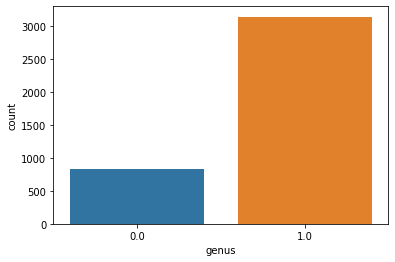

In [6]:
# Summarise label details in training data
sns.countplot(x=df_train['genus'])

Let's write a function to load images.

In [8]:
# parameters
# ids - list of image ids
# folder_path - path to image folder
# dim - dimensions to resize images
def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
      img = cv2.resize(img, dim)
    images.append(img)
  return images

In [9]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

Number of training images loaded: 3969
Number of testing images loaded: 6


## Feature extraction and model generation

In [23]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['0', '1']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=[0, 1])
  return accuracy, confusion_matrix

### SVM

In [17]:
def build_svm_model(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED) 
  clf.fit(X_train, y_train)
  return clf

#### Model M1

- Preprocessing - gray scaling<br>
- Features - image vector<br>
- Algorithm - SVM <br>

In [12]:
# method to get image features
def get_features_m1(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [18]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

(3969, 40000)


In [21]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m1 = build_svm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7027707808564232


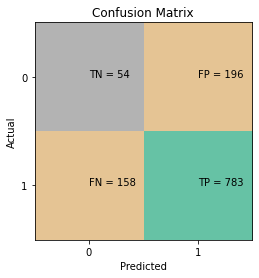

In [24]:
# make predictions on validation data
y_pred = m1.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)


Make predictions on test images

In [28]:
# feature extraction - test data
features_test = get_features_m1(test_images)
print(features_test.shape)

# get model predictions
predictions = m1.predict(features_test)
print(predictions)

(6, 40000)
[1. 1. 0. 0. 1. 0.]


#### Model M2

- Preprocessing - gray scaling, smoothing <br>
- Features - image vector<br>
- Algorithm - SVM <br>

To smooth images, we learned 2 commonly used techniques: box filtering and Gaussian filtering. Among them Gaussian filtering is used with this example.

Let's pick a random sample from images to see how smoothing affects them and to get an idea on suitable parameter settings. 

Note - This part is optional for the main flow. 

Image Id: 596
Image Id: 1882
Image Id: 1863
Image Id: 3898
Image Id: 3157


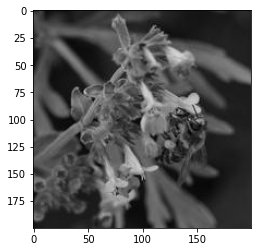

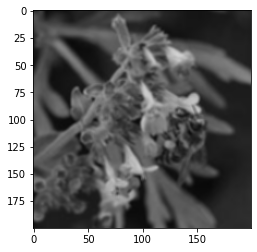

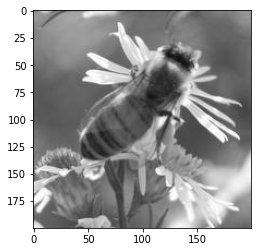

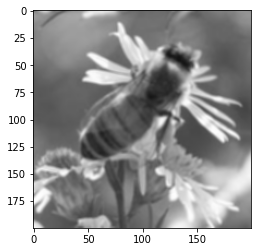

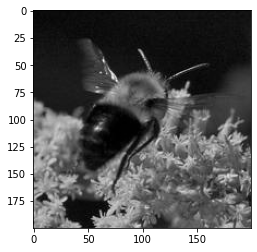

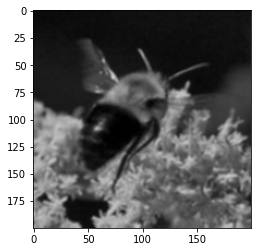

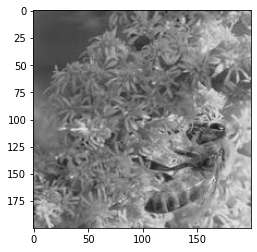

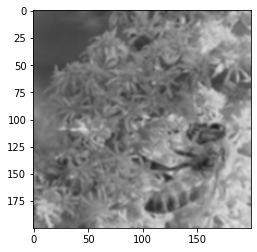

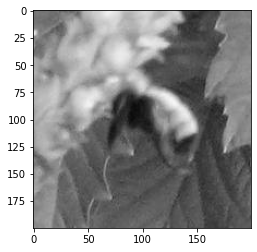

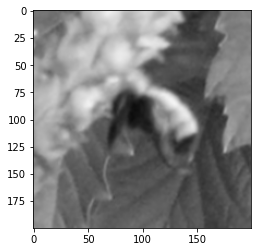

In [29]:
seed(RANDOM_SEED)
sample_images = []

# pick random sample of images
for i in range(5):
  value = randint(0, len(train_images)-1)
  print(f'Image Id: {value}')
  sample_images.append(train_images[value])

# apply preprocessing and show output images
for img in sample_images:
  img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.imshow(cv2.cvtColor(img_grayscaled, cv2.COLOR_BGR2RGB))
  plt.show()

  img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)
  plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
  plt.show()

In [30]:
# method to get image features
def get_features_m2(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [31]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

(3969, 40000)


In [32]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m2 = build_svm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.6817800167926112


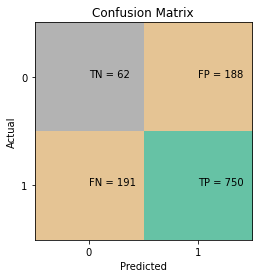

In [34]:
# make predictions on validation data
y_pred = m2.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

Make predictions on test images

In [35]:
# feature extraction - test data
features_test = get_features_m2(test_images)
print(features_test.shape)

# get model predictions
predictions = m2.predict(features_test)

print(predictions)

(6, 40000)
[0. 1. 0. 0. 1. 0.]


#### Model M3

- Preprocessing - gray scaling <br>
- Features - edge map to vector<br>
- Algorithm - SVM <br>

For edge detection, we use Canny edge detection algorithm in this example.

In [36]:
# method to get image features
def get_features_m3(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [37]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

(3969, 40000)


In [38]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m3 = build_svm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7884130982367759


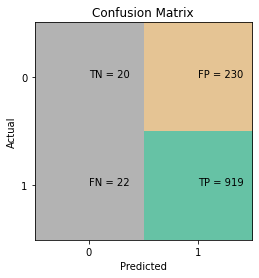

In [39]:
# make predictions on validation data
y_pred = m3.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

Make predictions on test images

In [40]:
# feature extraction - test data
features_test = get_features_m3(test_images)
print(features_test.shape)

# get model predictions
predictions = m3.predict(features_test)

print(predictions)

(6, 40000)
[1. 1. 1. 1. 1. 1.]


#### Model M4
- Preprocessing - gray scaling <br>
- Features - HOG features<br>
- Algorithm - SVM <br>

In [41]:
# method to get image features
def get_features_m4(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [42]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

(3969, 3780)


In [43]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m4 = build_svm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.670864819479429


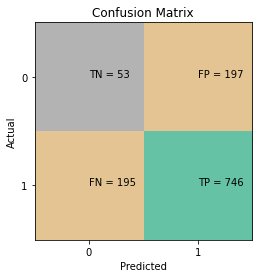

In [44]:
# make predictions on validation data
y_pred = m4.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

Make predictions on test images

In [45]:
# feature extraction - test data
features_test = get_features_m4(test_images)
print(features_test.shape)

# get model predictions
predictions = m4.predict(features_test)
print(predictions)

(6, 3780)
[1. 0. 1. 1. 1. 1.]


Make predictions on test images

#### Summary

|Model | Preprocessing | Features   | Accuracy|
|------|---------------|------------|---------|
|M1    | gray scaling   | image vector | 0.7028 |
|M2    | gray scaling, smoothing| image vector | 0.6818 |
|M3    | gray scaling | edge map to vector | 0.7884 |
|M4    | gray scaling | HOG features | 0.6709 |


#### Model M5

Let's try to combine features.

- Preprocessing - gray scaling <br>
- Features - image vector + edge map vector<br>
- Algorithm - SVM <br>

In [51]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

More details about numpy.hstack are available with the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

Train and validate model

In [52]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

(3969, 80000)


In [53]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m5 = build_svm_model(X_train, X_val, y_train, y_val)

Accuracy: 0.7674223341729639


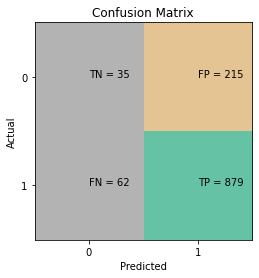

In [54]:
# make predictions on validation data
y_pred = m5.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

Make predictions on test images

In [55]:
# feature extraction - test data
features_test = get_features_m5(test_images)
print(features_test.shape)

# get model predictions
predictions = m5.predict(features_test)
print(predictions)

(6, 80000)
[1. 1. 1. 1. 1. 1.]


**Exercise**

1. Apply PCA to the best model built above and see the impact of dimensionality reduction on the model's accuracy.

2. Check other possible image preprocessing and feature combinations and see whether they can improve the model's accuracy. Also, try tuning hyper-parameters of the SVM algorithm based on the knowledge you gained during the Machine Learning module.

3. Apply other classification algorithms you learned for this task and analyse their performance. 